In [ ]:
# Appendix A.1: Data Cleaning and Preprocessing step
import pandas as pd

# Load dataset
file_path = "/content/sales_data.csv"
df = pd.read_csv(file_path)


# 1. Standardize column names

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# 2. Handle Date column

df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 3. Check for duplicates

df = df.drop_duplicates()
print("Total Duplicate rows in Dataset:", df.duplicated().sum())

# 4. Handle missing values

# Numeric: fill with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
print("Total Missing Values in Dataset:", df.isnull().sum().sum())


# Categorical: fill with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
print("Total Null Categorical Columns in Dataset:", df.isnull().sum().sum())

# 6. Outlier handling

# Example: cap extreme prices at 99th percentile
price_cap = df['price'].quantile(0.99)
df['price'] = df['price'].clip(upper=price_cap)
print("Total Outliers in the Dataset:", df.shape[0] - df.dropna().shape[0])

# 7. Create useful features

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()

# 8. Save cleaned dataset

df.to_csv("sales_data_cleaned.csv", index=False)

print("Cleaning complete. Shape:", df.shape)
print(df.shape)


Total Duplicate rows in Dataset: 0
Total Missing Values in Dataset: 0
Total Null Categorical Columns in Dataset: 0
Total Outliers in the Dataset: 0
Cleaning complete. Shape: (76000, 20)
(76000, 20)



Normal SARIMA Metrics:
MAE: 1423.57
RMSE: 2105.19
MAPE: 18.11%


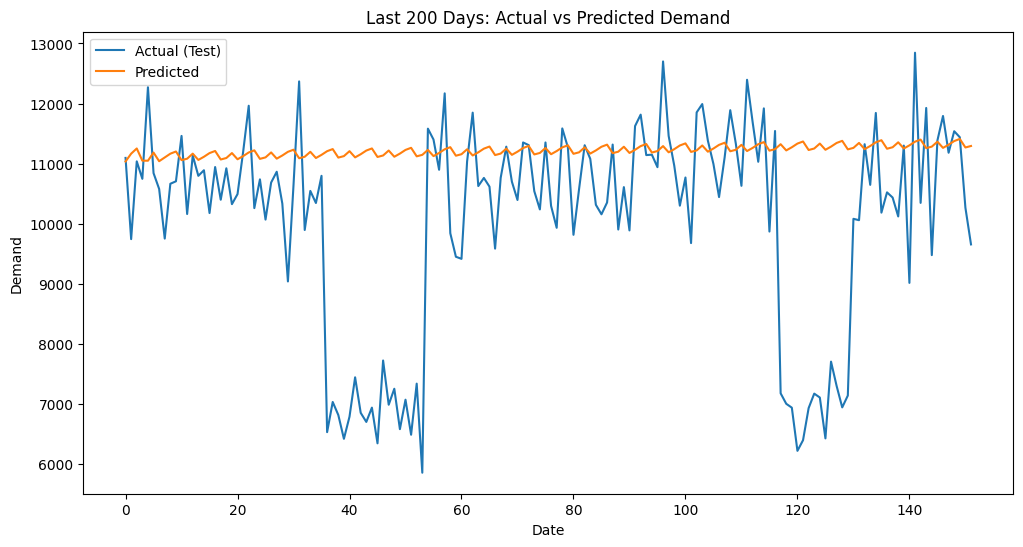

In [ ]:
# ==============================
# Appendix A.2: Forecasting Models Implementatio
# Normal SARIMA (fixed params) Normal SARIMA Metrics: MAE: 1423.57 RMSE: 2105.19 MAPE: 18.11%
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
file_path = '/content/sales_data_cleaned.csv'
data = pd.read_csv(file_path)

# Preprocessing
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.sort_index()

# Aggregate daily demand
daily_demand = data['demand'].resample('D').sum()

# Train-test split (80%-20%)
train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

# Normal SARIMA model (fixed params)
np.random.seed(42)  # reproducibility
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
forecast_series = pd.Series(forecast, index=test.index)

# Metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nNormal SARIMA Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


# ==============================
# Visualization: Last 200 Test vs Predicted
# ==============================
plt.figure(figsize=(12,6))
plt.plot(test[-200:].values, label="Actual (Test)")
plt.plot(forecast[-200:].values, label="Predicted")
plt.title("Last 200 Days: Actual vs Predicted Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


Best SARIMA config: ((1, 0, 0), (1, 1, 1, 7))
Best MAPE: 15.497729363905451

Final Evaluation Metrics for Best SARIMA:
MAE: 1252.21
RMSE: 1807.43
MAPE: 15.50%


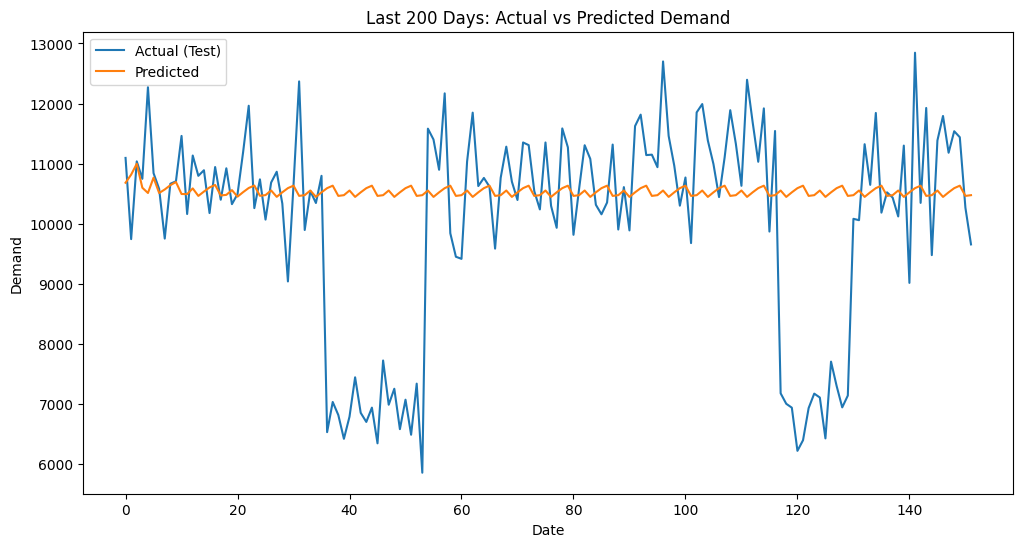

In [ ]:
# SARIMA Forecasting Model with Hyperparameter Tuning using GridSearch MAE: 1252.21 RMSE: 1807.43 MAPE: 15.50%
# ==============================
# 1. Install dependencies
# ==============================
!pip install statsmodels

# ==============================
# 2. Import libraries
# ==============================
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 3. Load dataset
# ==============================
file_path = "/content/sales_data_cleaned.csv"  # update path if needed
data = pd.read_csv(file_path)

# ==============================
# 4. Preprocessing
# ==============================
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data = data.sort_index()

# Aggregate daily demand
daily_demand = data['demand'].resample('D').sum()

# Train-test split (80%-20%)
train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

# ==============================
# 5. Define parameter grid
# ==============================
p = d = q = range(0, 3)      # Non-seasonal params
P = D = Q = range(0, 2)      # Seasonal params
m = 7                        # Weekly seasonality

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_score = float("inf")
best_cfg = None
best_model = None

# ==============================
# 6. Grid Search SARIMA
# ==============================
for param in pdq:
    for seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                            order=param,
                            seasonal_order=seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            # Forecast on test
            forecast = model_fit.predict(start=len(train),
                                         end=len(train)+len(test)-1,
                                         dynamic=False)

            # Calculate MAPE
            mape = np.mean(np.abs((test - forecast) / test)) * 100

            if mape < best_score:
                best_score = mape
                best_cfg = (param, seasonal)
                best_model = model_fit
        except:
            continue

print("Best SARIMA config:", best_cfg)
print("Best MAPE:", best_score)

# ==============================
# 7. Evaluate on Test
# ==============================
forecast = best_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("\nFinal Evaluation Metrics for Best SARIMA:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# ==============================
# Visualization: Last 200 Test vs Predicted
# ==============================
plt.figure(figsize=(12,6))
plt.plot(test[-200:].values, label="Actual (Test)")
plt.plot(forecast[-200:].values, label="Predicted")
plt.title("Last 200 Days: Actual vs Predicted Demand")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()



Epoch 1/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 100s 48ms/step - loss: 0.0129 - val_loss: 0.0093
Epoch 2/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 3/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 86s 45ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 4/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 5/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 6/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 7/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 138s 42ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 8/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 87s 45ms/step - loss: 0.0110 - val_loss: 0.0093
Epoch 9/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 137s 42ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 10/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 85s 45ms/step - loss: 0.0108 - val_loss: 0.0093
Epoch 11/20
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 136s 42ms/step - loss: 0.0109 - val_loss: 0.0093
Epoc

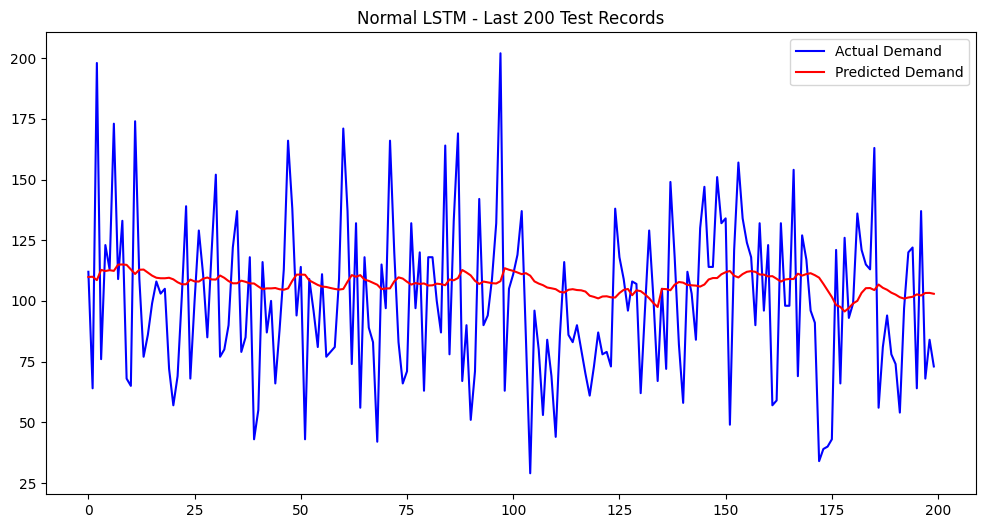

In [ ]:
# simple LSTM Forecasting Model MAE  : 32.67 RMSE : 41.15 MAPE : 51.03%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ================================
# 1. Load dataset
# ================================
df = pd.read_csv("/content/sales_data_cleaned.csv", parse_dates=['date'])
df.set_index('date', inplace=True)

# Target variable
y = df['demand'].values.reshape(-1, 1)

# ================================
# 2. Scale data
# ================================
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

# ================================
# 3. Train-Test Split
# ================================
train_size = int(len(y_scaled) * 0.8)
train, test = y_scaled[:train_size], y_scaled[train_size:]

# ================================
# 4. Create sequences
# ================================
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ================================
# 5. Build Normal LSTM Model
# ================================
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ================================
# 6. Train Model
# ================================
model.fit(X_train, y_train, epochs=20, batch_size=32,
          validation_data=(X_test, y_test), verbose=1)

# ================================
# 7. Forecast & Inverse Transform
# ================================
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler.inverse_transform(y_test)

# ================================
#  Evaluation Metrics
# ================================
mae = mean_absolute_error(y_test_rescaled, y_pred)
rmse = mean_squared_error(y_test_rescaled, y_pred) ** 0.5  # sqrt(MSE)
mape = np.mean(np.abs((y_test_rescaled - y_pred) / y_test_rescaled)) * 100

print("\n📊 Normal LSTM Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# ================================
# 8. Visualization (Last 200 records)
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[-200:], label="Actual Demand", color='blue')
plt.plot(y_pred[-200:], label="Predicted Demand", color='red')
plt.legend()
plt.title("Normal LSTM - Last 200 Test Records")
plt.show()

Trial 5 Complete [00h 05m 21s]
val_loss: 0.009293175302445889

Best val_loss So Far: 0.009280874393880367
Total elapsed time: 00h 30m 33s

🎯 Best Hyperparameters:
LSTM units1      : 64
LSTM units2      : 64
Dropout1         : 0.5
Dropout2         : 0.2
Learning rate    : 0.0037960142342107427
Sequence length  : 15
Epoch 1/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0125 - val_loss: 0.0100
Epoch 2/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 3/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 4/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 5/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 6/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 7/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 8/50
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss:

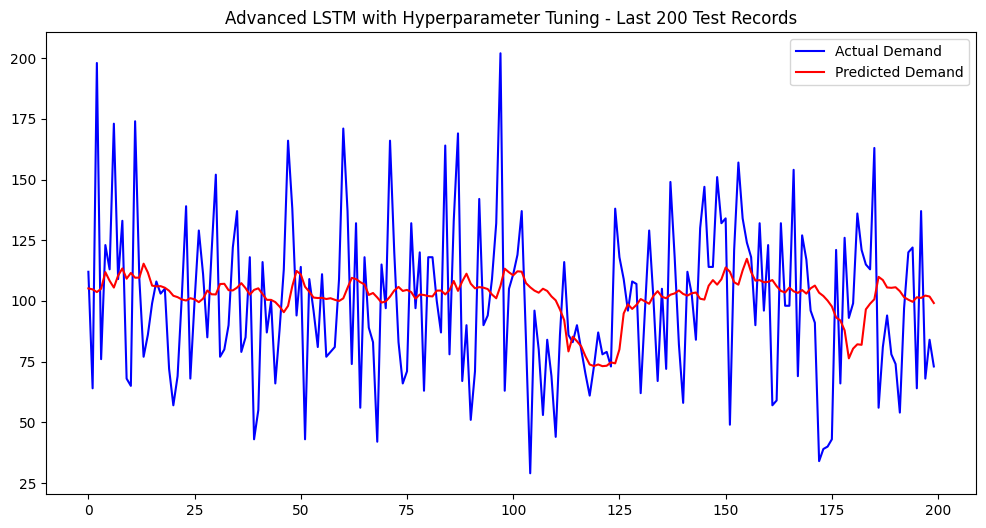

In [ ]:
# LSTM forecasting Model with Random Search Hyperparameter Tuning via keras tuner. MAE  : 32.71 RMSE : 41.40 MAPE : 50.63%
!pip install keras-tuner --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

# ================================
# 1. Load dataset
# ================================
df = pd.read_csv("/content/sales_data_cleaned.csv", parse_dates=['date'])
df.set_index('date', inplace=True)
y = df['demand'].values.reshape(-1, 1)

# ================================
# 2. Scale data
# ================================
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

# ================================
# 3. Train-Test Split
# ================================
train_size = int(len(y_scaled) * 0.8)
train, test = y_scaled[:train_size], y_scaled[train_size:]

# ================================
# 4. Function to create sequences
# ================================
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# ================================
# 5. Hyperparameter Tuning Function
# ================================
def build_model(hp):
    seq_length = hp.Int('seq_length', min_value=10, max_value=60, step=5)

    # Create sequences with current sequence length
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units1', min_value=32, max_value=128, step=32),
        activation='relu',
        return_sequences=True,
        input_shape=(seq_length, 1)
    ))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(
        units=hp.Int('units2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mse'
    )
    return model

# ================================
# 6. Initialize Keras Tuner
# ================================
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,        # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='sales_forecasting'
)

# ================================
# 7. Prepare sequences for tuner
# ================================
# Using a fixed seq_length for initial tuning
seq_length = 30
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ================================
# 8. Search Best Hyperparameters
# ================================
tuner.search(X_train, y_train, epochs=20, batch_size=32,
             validation_data=(X_test, y_test), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n🎯 Best Hyperparameters:")
print(f"LSTM units1      : {best_hps.get('units1')}")
print(f"LSTM units2      : {best_hps.get('units2')}")
print(f"Dropout1         : {best_hps.get('dropout1')}")
print(f"Dropout2         : {best_hps.get('dropout2')}")
print(f"Learning rate    : {best_hps.get('learning_rate')}")
print(f"Sequence length  : {best_hps.get('seq_length')}")

# ================================
# 9. Train Final Model with Best Hyperparameters
# ================================
final_seq_length = best_hps.get('seq_length')
X_train, y_train = create_sequences(train, final_seq_length)
X_test, y_test = create_sequences(test, final_seq_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

# ================================
# 10. Forecast & Inverse Transform
# ================================
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler.inverse_transform(y_test)

# ================================
# 11. Evaluation Metrics
# ================================
mae = mean_absolute_error(y_test_rescaled, y_pred)
rmse = mean_squared_error(y_test_rescaled, y_pred) ** 0.5
mape = np.mean(np.abs((y_test_rescaled - y_pred) / y_test_rescaled)) * 100

print("\n📊 Advanced LSTM Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# ================================
# 12. Visualization
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[-200:], label="Actual Demand", color='blue')
plt.plot(y_pred[-200:], label="Predicted Demand", color='red')
plt.legend()
plt.title("Advanced LSTM with Hyperparameter Tuning - Last 200 Test Records")
plt.show()



Evaluation Metrics on Test Data:
MAE: 24.14
RMSE: 31.24
MAPE: 26.79%

Predictions saved to xgboost_predictions_full.csv


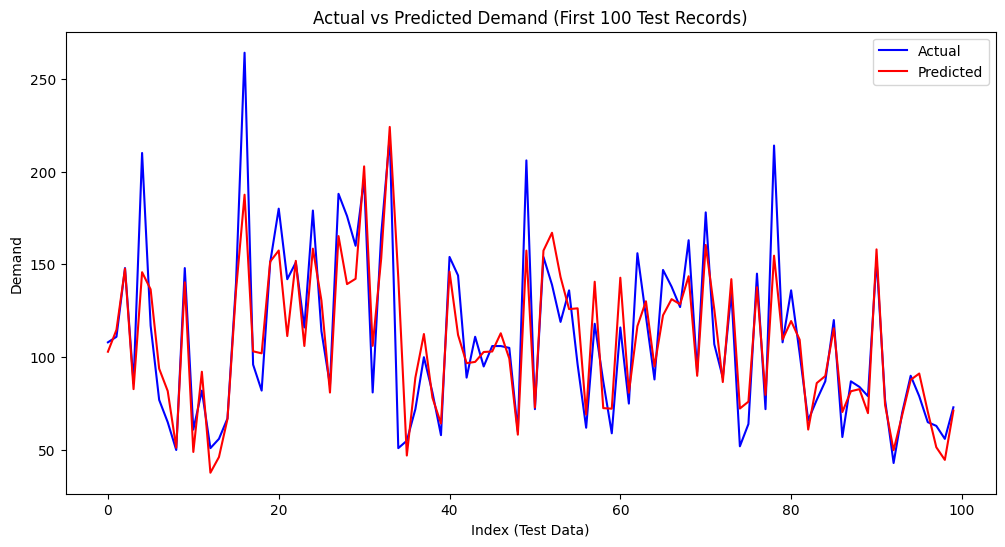

In [ ]:
# XGBoost Forecasting model plain. MAE: 24.14 RMSE: 31.24 MAPE: 26.79%
# ==============================
# Install Dependencies
# ==============================
!pip install xgboost scikit-learn pandas matplotlib --quiet

# ==============================
# Import Libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Fix seeds
np.random.seed(42)
random.seed(42)

# ==============================
# 1. Load dataset
# ==============================
df = pd.read_csv("/content/sales_data_cleaned.csv", parse_dates=['date'])

# ==============================
# 2. Feature Engineering (per store & product)
# ==============================
df = df.sort_values(["store_id","product_id","date"])

# --- Calendar features ---
df["dayofweek"] = df["date"].dt.dayofweek   # 0=Mon, 6=Sun
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter
df["year"] = df["date"].dt.year
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# --- Lag features per group ---
df['lag_1'] = df.groupby(['store_id','product_id'])['demand'].shift(1)
df['lag_7'] = df.groupby(['store_id','product_id'])['demand'].shift(7)
df['lag_14'] = df.groupby(['store_id','product_id'])['demand'].shift(14)
df['lag_30'] = df.groupby(['store_id','product_id'])['demand'].shift(30)

# --- Rolling means ---
df['rolling_mean_7'] = df.groupby(['store_id','product_id'])['demand'].shift(1).rolling(window=7).mean()
df['rolling_mean_30'] = df.groupby(['store_id','product_id'])['demand'].shift(1).rolling(window=30).mean()

# Drop NA (from lags)
df = df.dropna().reset_index(drop=True)

# ==============================
# 3. Features and Target
# ==============================
X = df.drop(columns=['demand','date'])
y = df['demand']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ==============================
# 4. Train-Test Split (80/20 chronological)
# ==============================
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# ==============================
# 5. Normal XGBoost Model (Fixed Parameters)
# ==============================
xgb_params = {
    "n_estimators": 500,
    "max_depth": 8,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0,
    "min_child_weight": 5,
    "random_state": 42,
    "n_jobs": -1
}

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', XGBRegressor(**xgb_params))])

# ==============================
# 6. Train Model
# ==============================
model.fit(X_train, y_train)

# ==============================
# 7. Predictions
# ==============================
y_pred_test = model.predict(X_test)
y_pred_all = model.predict(X)

# ==============================
# 8. Evaluation Metrics
# ==============================
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"\nEvaluation Metrics on Test Data:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%")

# ==============================
# 9. Save Predictions
# ==============================
predictions_df = pd.DataFrame({
    'date': df['date'],
    'store_id': df['store_id'],
    'product_id': df['product_id'],
    'seasonality': df['seasonality'],
    'weather_condition': df['weather_condition'],
    'epidemic': df['epidemic'],
    'demand': df['demand'],
    'predicted_demand': np.round(y_pred_all).astype(int)
})

# Sort final predictions
predictions_df = predictions_df.sort_values(by=["date", "store_id", "product_id"]).reset_index(drop=True)
predictions_df.to_csv('xgboost_predictions_full.csv', index=False)
print("\nPredictions saved to xgboost_predictions_full.csv")

# ==============================
# 10. Visualization (First 100 test records)
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", color="blue")
plt.plot(y_pred_test[:100], label="Predicted", color="red")
plt.title("Actual vs Predicted Demand (First 100 Test Records)")
plt.xlabel("Index (Test Data)")
plt.ylabel("Demand")
plt.legend()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 23.4 MB/s eta 0:00:00


[I 2025-09-02 11:52:11,541] A new study created in memory with name: no-name-db0a1d17-c266-436e-92ed-75dcc91cff24
[I 2025-09-02 11:52:31,696] Trial 0 finished with value: 20.652495377717184 and parameters: {'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.2209382128343645, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 2}. Best is trial 0 with value: 20.652495377717184.
[I 2025-09-02 11:52:48,844] Trial 1 finished with value: 28.285876632167135 and parameters: {'n_estimators': 893, 'max_depth': 9, 'learning_rate': 0.21388141044983341, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 5}. Best is trial 0 with value: 20.652495377717184.
[I 2025-09-02 11:52:52,814] Trial 2 finished with value: 15.924059914793476 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.09475146167306363, 'subsample': 0.762378215816119, 'co

Best Parameters: {'n_estimators': 742, 'max_depth': 7, 'learning_rate': 0.007015057096018568, 'subsample': 0.6005485068101236, 'colsample_bytree': 0.9277486331535513, 'gamma': 3.6311057738214814, 'min_child_weight': 14}

Evaluation Metrics on Test Data:
MAE: 12.96
RMSE: 17.22
MAPE: 13.63%

Predictions saved to xgboost_predictions_full.csv


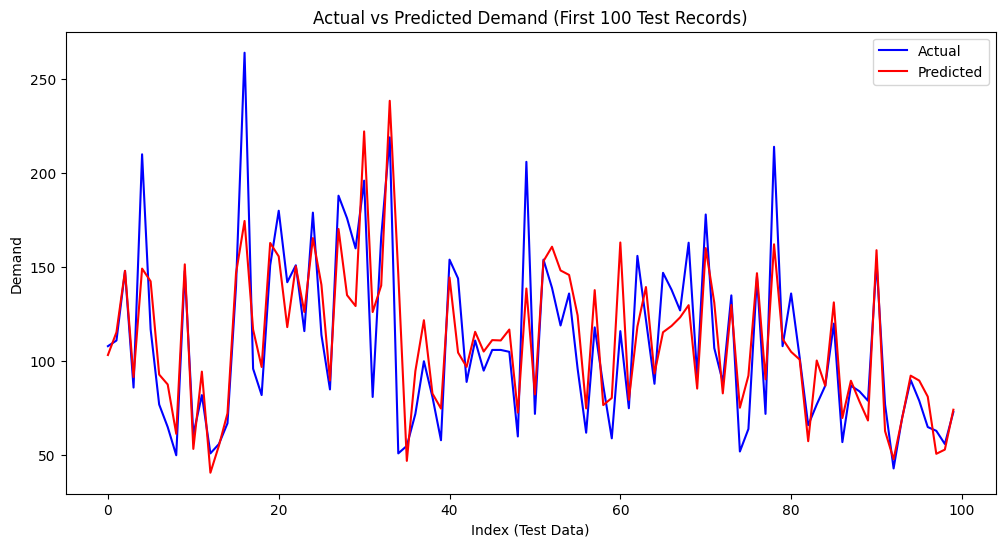

In [ ]:
# Model XGBoost with Hyperparameter tuning using optuna MAE: 12.96 RMSE: 17.22 MAPE: 13.63%
# ==============================
# Install Dependencie
# ==============================
!pip install optuna xgboost scikit-learn pandas matplotlib --quiet

# ==============================
# Import Libraries
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Fix seeds
np.random.seed(42)
random.seed(42)

# ==============================
# 1. Load dataset
# ==============================
df = pd.read_csv("/content/sales_data_cleaned.csv", parse_dates=['date'])

# ==============================
# 2. Feature Engineering (per store & product)
# ==============================
df = df.sort_values(["store_id","product_id","date"])

# --- Calendar features ---
df["dayofweek"] = df["date"].dt.dayofweek   # 0=Mon, 6=Sun
df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter
df["year"] = df["date"].dt.year
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# --- Lag features per group ---
df['lag_1'] = df.groupby(['store_id','product_id'])['demand'].shift(1)
df['lag_7'] = df.groupby(['store_id','product_id'])['demand'].shift(7)
df['lag_14'] = df.groupby(['store_id','product_id'])['demand'].shift(14)
df['lag_30'] = df.groupby(['store_id','product_id'])['demand'].shift(30)

# --- Rolling means ---
df['rolling_mean_7'] = df.groupby(['store_id','product_id'])['demand'].shift(1).rolling(window=7).mean()
df['rolling_mean_30'] = df.groupby(['store_id','product_id'])['demand'].shift(1).rolling(window=30).mean()

# Drop NA (from lags)
df = df.dropna().reset_index(drop=True)

# ==============================
# 3. Features and Target
# ==============================
X = df.drop(columns=['demand','date'])
y = df['demand']

categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# ==============================
# 4. Train-Test Split (80/20 chronological)
# ==============================
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# ==============================
# 5. Optuna Objective
# ==============================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "random_state": 42
    }
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', XGBRegressor(**params))])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mape = np.mean(np.abs((y_test - preds) / y_test)) * 100
    return mape

# ==============================
# 6. Run Optuna (More Trials)
# ==============================
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best Parameters:", best_params)

# ==============================
# 7. Train Final Model
# ==============================
final_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', XGBRegressor(**best_params, random_state=42))])
final_model.fit(X_train, y_train)

# ==============================
# 8. Predictions
# ==============================
y_pred_test = final_model.predict(X_test)
y_pred_all = final_model.predict(X)

# ==============================
# 9. Evaluation Metrics
# ==============================
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print(f"\nEvaluation Metrics on Test Data:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%")

# ==============================
# 10. Save Predictions
# ==============================
predictions_df = pd.DataFrame({
    'date': df['date'],
    'store_id': df['store_id'],
    'product_id': df['product_id'],
    'seasonality': df['seasonality'],
    'weather_condition': df['weather_condition'],
    'epidemic': df['epidemic'],
    'demand': df['demand'],
    'predicted_demand': np.round(y_pred_all).astype(int)
})

# Sort final predictions
predictions_df = predictions_df.sort_values(by=["date", "store_id", "product_id"]).reset_index(drop=True)
predictions_df.to_csv('xgboost_predictions_full.csv', index=False)
print("\nPredictions saved to xgboost_predictions_full.csv")

# ==============================
# 11. Visualization (First 100 test records)
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label="Actual", color="blue")
plt.plot(y_pred_test[:100], label="Predicted", color="red")
plt.title("Actual vs Predicted Demand (First 100 Test Records)")
plt.xlabel("Index (Test Data)")
plt.ylabel("Demand")
plt.legend()
plt.show()


In [ ]:
# Appendix A.3: Mini-Dataset-Creation
import pandas as pd

# Load model prediction file (already saved from your forecasting stage)
df = pd.read_csv("/content/xgboost_predictions_full.csv")

# Step 1: Select 2 stores
selected_stores = ['S002', 'S003']   # replace with store IDs you want
df_filtered = df[df['store_id'].isin(selected_stores)]

# Step 2: Select 4 products
selected_products = ['P0004', 'P0009', 'P0018','P0020']   # replace with chosen product IDs
df_filtered = df_filtered[df_filtered['product_id'].isin(selected_products)]

# Step 3: Choose last 7 days (e.g., last 7 days available in dataset)
last_days = df_filtered['date'].sort_values().unique()[-7:]
df_final = df_filtered[df_filtered['date'].isin(last_days)]

# Save mini-dataset
df_final.to_csv("mini_dataset.csv", index=False)

print("Mini-dataset created with shape:", df_final.shape)


Mini-dataset created with shape: (56, 8)
